In [1]:
import numpy as np
#from scipy.integrate import solve_ivp
#from scipy.signal import spectrogram
import matplotlib.pyplot as plt
#from piaxi_numerics import set_params, solve_system, get_text_params

verbosity = 9
use_tex_format = False

In [2]:
# LaTeX Formatting for Plots
if use_tex_format:
    plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

    SMALL_SIZE = 8
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    '''plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the x tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the y tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', labelsize=BIGGER_SIZE, titlesize=BIGGER_SIZE)  # fontsize of the figure title'''

# Scratchwork

In [3]:
# TODO
sklearn_process = False
if sklearn_process:
    from sklearn.neural_network import MLPClassifier, MLPRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC

    ## TODO: Data generation, importing, and preprocessing

    # TODO: load dataset
    from sklearn.datasets import make_classification
    X, y = make_classification(random_state = 0, n_features = 20, n_informative = 18, n_classes = 3)

    # TODO: split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [4]:
# TODO
if sklearn_process:
    # Create dataset processing and classification pipeline
    model_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
    model_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(max_iter=400))])
    models = [model_svc, model_mlp]

    # Fit model to training dataset
    for model in models:
        print(list(model.named_steps.keys())[1])
        model.fit(X_train, y_train)
        # Evaluate fit with test dataset
        print("Score: %.2f" % model.score(X_test, y_test))
        print(" --------------------------------------- ")

# Misc. Tools

In [5]:
## Optionally solve for certain model-dependent parameters
if True:
    from piaxi_utils import fit_Fpi
    
    eps_in = 1e-10
    l1_in  = 1
    m_axion = 1e-10     # desired QCD axion reference mass
    
    F_fit = fit_Fpi(m_axion, eps_in, l1_in, fit_QCD=True, verbosity=9)

Fitting pi-axiverse to QCD axion parameter space
QCD    |    m_a  = 1.0e-10 [eV]
       |    g_a  = 3.8e-20 [GeV^-1]
       |    z_ag = 5.2e-02
       |    C_ag = 1.9e+00
pi-axi |    eps  = 1.0e-10   ----->   F_pi = 5.2e-01 [GeV]   ----->   m_I = 1.9e-29 [eV]
       |    m_pi = 1.0e-10 [eV]
       |    g_pi = 3.8e-20 [GeV^-1]
       |    z_pi = 5.2e-02
       |    C_pi = -1.7e-17


# Analysis

In [6]:
## Plot Single Case
if False:
    from piaxi_utils import plot_single_case, load_single_result
    
    #plot_single_case('3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3.json', output_dir='./test_data/', version='v2.8', tex_fmt=use_tex_format)
    plot_single_case('debug_bbbcfee89c436a9c11885e23159ef57a33e53985.json', output_dir='./scratch/', version='v3.2', tex_fmt=use_tex_format, add_colorbars=True, k_samples_in=[-1])

In [7]:
## TODO/WIP: Properly label and/or mask forbidden or experimentally excluded regions of parameter space
# TODO: Plot theoretically forbidden regions on AxionPhoton plots?
def enforce_constraints(series_in):
    """Enforce a series of optional constraints on parameter space selections."""

    # Label whether or not F_pi and QCD axion conform to desired relations
    series_in['fit_F_pi'] = check_Fpi_fit(series_in['eps'], series_in['m_u'], series_in['l1'], series_in['F'], sens=2., fit_QCD=False, verbosity=0)
    series_in['fit_QCD']  = check_Fpi_fit(series_in['eps'], series_in['m_u'], series_in['l1'], series_in['F'], sens=2., fit_QCD=True,  verbosity=0)

    # WIP: Enforce cosmologically stable lifetimes
    is_cosmo_stable = lambda m_in, F_pi=series_in['F'], eps=series_in['eps']: cosmo_stability(m_in, F_pi, eps) <= 1.2

    ## Freeze-in Relic Density for charged species
    H_infl = 1e19   # Hubble at Inflation [eV]
    T_re   = 1e18   # Temperature of reheating [eV]
    w_re   = 0      # Equation of state (at reheating)
    M_pl   = 1.2e27 # Planck Mass [eV]
    rd_a = lambda m_in, H=H_infl, M=M_pl: m_in/np.sqrt(H*M)
    rd_b = lambda T=T_re, H=H_infl, M=M_pl: np.sqrt(H*M)/T
    relic_density_charged = lambda m_in, F_pi, eps, w=w_re, H=H_infl, T=T_re, M=M_pl: \
        (5e-3) * (((10*np.pi**2)**(-w/(1+w)))/(2*(1+w))) * (eps**4) * (np.exp(10*(3-rd_a(m_in,H,M)*np.sqrt(rd_b(T,H,M))))/(rd_b(T,H,M)**(4/(1+w)-(1/2))))

    # WIP: Enforce minimal charged relic density
    omega_c = np.sum([relic_density_charged(mc_in, F_pi=series_in['F'], eps=series_in['eps']) for mc_in in series_in['m'][2]])
    is_crd_min = lambda m_in: relic_density_charged(m_in, F_pi=series_in['F'], eps=series_in['eps']) <= 0.01
    
    return series_in

## Distribution Analysis

In [8]:
## Dependency imports and declarations for data preprocessing, unit handling, and print formatting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from piaxi_utils import load_all, load_case, get_units_from_params, classify_resonance, n_p, n_k, cosmo_stability, fit_Fpi, check_Fpi_fit

#np.warnings.filterwarnings("error", category=np.VisibleDeprecationWarning)

# Set dtypes and print formats for each column
param_map = {
    "config_name":       [str,             None],
    "units":             ['object',        None],
    "A_0":               [np.float32,      None],
    "A_pm":              [np.int32,        None],
    "A_sens":            [np.float32,      None],
    "Adot_0":            [np.float32,      None],
    "F":                 [np.float64,      'sci'],
    "G":                 [np.float64,      'sci'],
    "L3":                [np.float64,      'sci'],
    "L4":                [np.float64,      'sci'],
    "N_c":               [np.int32,        None],
    "N_n":               [np.int32,        None],
    "N_r":               [np.int32,        None],
    "N_tot":             [np.int32,        None],
    "Th":                [np.ndarray,      'pi'],
    "amps":              [np.ndarray,      'sci'],
    "c":                 [np.float32,      'sci'],
    "d":                 [np.ndarray,      'pi'],
    "dqm":               [np.ndarray,      'sci'],
    "e":                 [np.float32,      None],
    "eps":               [np.float64,      'sci'],
    "eps_c":             [np.ndarray,      'int'],
    "h":                 [np.float64,      'sci'],
    "int_method":        [str,             None],
    "jupyter":           ['Int64',         None],
    "k_0":               [np.float32,      'sci'],
    "k_class_arr":       [np.ndarray,      None],
    "k_mean_arr":        [np.ndarray,      None],
    "k_num":             [np.int32,        'int'],
    "k_peak_arr":        [np.ndarray,      'sci'],
    "k_ratio_arr":       [np.ndarray,      'sci'],
    #"k_sens_arr":        [np.ndarray,      None],
    "k_span":            [np.ndarray,      'float'],
    "l1":                [np.int32,        None],
    "l2":                [np.int32,        None],
    "l3":                [np.int32,        None],
    "l4":                [np.int32,        None],
    "m":                 [np.ndarray,      'sci'],
    "m_0":               [np.float64,      'sci'],
    "m_c":               [np.ndarray,      'sci'],
    "m_n":               [np.ndarray,      'sci'],
    "m_q":               [np.float64,      'sci'],
    "m_r":               [np.ndarray,      'sci'],
    "m_u":               [np.float64,      'sci'],
    "mem_per_core":      ['Int64',         None],
    "mu_Th":             [np.float32,      'pi'],
    "mu_d":              [np.float32,      'pi'],
    "num_cores":         [np.int32,        None],
    "p":                 [np.ndarray,      'sci'],
    "p_0":               [np.float64,      'sci'],
    "p_c":               [np.ndarray,      'sci'],
    "p_n":               [np.ndarray,      'sci'],
    "p_r":               [np.ndarray,      'sci'],
    "p_t":               [np.float64,      'sci'],
    "parallel":          [bool,            None],
    "qc":                [np.ndarray,      'float'],
    "qm":                [np.ndarray,      'sci'],
    "res_band":          [np.ndarray,      'sci'],
    "res_band_class":    [str,             None],
    "res_class":         [str,             None],
    "res_con":           [np.float32,      None],
    "res_freq":          [str,             None],
    "res_freq_class":    ['object',        None],
    "res_freq_label":    [str,             None],
    "res_ratio_f":       [np.float64,      'sci'],
    "res_ratio_m":       [np.float64,      'sci'],
    "rescale_amps":      [bool,            None],
    "rescale_consts":    [bool,            None],
    "rescale_k":         [bool,            None],
    "rescale_m":         [bool,            None],
    "seed":              [str,             None],
    "sig_Th":            [np.float32,      'pi'],
    "sig_d":             [np.float32,      'pi'],
    "t_num":             [np.int32,        None],
    "t_res":             [np.float32,      'float'],
    "t_sens":            [np.float32,      'sci'],
    "t_span":            [np.ndarray,      'float'],
    "t_u":               [np.float64,      'sci'],
    "T_r":               [np.float32,      'float'],
    "T_n":               [np.float32,      'float'],
    "T_c":               [np.float32,      'float'],
    "T_u":               [np.float32,      'float'],
    "use_natural_units": [bool,            None],
    "use_mass_units":    [bool,            None],
    "dimensionful_p":    [bool,            None],
    "time_elapsed":      [str,             None],
    "unitful_amps":      [bool,            None],
    "unitful_k":         [bool,            None],
    "unitful_m":         [bool,            None],
    "xi":                [np.ndarray,      'float'],
}

dtype_map = {key: val[0] for key,val in param_map.items()}
print_fmt = {key: val[1] for key,val in param_map.items()}

#df[["A"]].describe().applymap(lambda x: f"{x:0.3f}")
def df_fmt(x, fmt=None):
    if pd.isna(x):
        return ''
    if type(x) in [float, np.float32, np.float64] or fmt in ['sci', 'pi', 'float']:
        if fmt == 'sci':
            return f'{x:.1e}'
        elif fmt == 'pi':
            xp = x/np.pi
            return f'{xp:0.1f}'
        else:
            return f'{x:0.1f}'
    elif type(x) in [int, np.int32, np.int64, 'Int64'] or fmt in ['int']:
        if x == 'None':
            return None
        else:
            return f'{x:d}'
    elif type(x) is str:
        if x.lower() == 'nan':
            return ''
        else:
            return x
    else:
        #print(x, type(x))
        return x

# WIP: Pretty printing dataframes
def df_pprint(df_in):
    df = df_in.copy()
    for param in df:
        df[param].apply(df_fmt, args=(print_fmt[param],))
    return df

def df_describe(df_in, use_pprint=False, include='all'):
    if use_pprint:
        return df_pprint(df_in.describe(include=include))
    else:
        return df_in.describe(include=include)

In [9]:
## Helper functions for data preprocessing
def prepare_data(config_name, output_root='~/scratch', version='v3.2.6', reclassify=None, load_images=False):
    """Load and prepare data for future functions"""

    if config_name == 'all':
        params, results, _, coeffs = load_all(output_root, version, load_images=load_images)
    else:
        params, results, _, coeffs = load_case(config_name, output_root, version, load_images=load_images)

    # Convert to DataFrame
    params_df  = pd.DataFrame(params)

    # Extract unit mappings
    units_in = params_df.pop('units')
    units_df = pd.DataFrame(units_in.tolist(), index=params_df.index)
    
    # TODO: Temp fix, remove this when no longer needed
    if int(version.replace('v','').split('.')[0]) <= 2:
        params_df['jupyter'].fillna(False, inplace=True)
    # TODO: Temp fix, remove this when no longer needed
    if int(version.replace('v','').split('.')[0]) <= 3:
        if 'N_tot' not in params_df.keys():
            params_df['N_tot'] = params_df['N_r'].astype(np.int32)+params_df['N_n'].astype(np.int32)+params_df['N_c'].astype(np.int32)

    # Preprocess stored parameter values and populate dataframe
    for col, dtype in dtype_map.items():
        #print('col: %s   |  dtype: %s' % (col,dtype))
        if col in params_df:
            try:
                if dtype is np.ndarray:
                    try:
                        params_df[col] = params_df[col].apply(np.array, dtype=object)
                    except (np.VisibleDeprecationWarning):
                        print('Deprecation: %s' % col)
                        print(params_df[col])
                        params_df[col] = params_df[col].apply(np.array)
                else:
                    params_df[col] = params_df[col].astype(dtype)
            except (OverflowError):
                print('Overflow: (%s) - %s' % (col, dtype))
        else:
            print('Missing parameter: %s' % col)
    n_cols = [ncol for ncol in params_df if ncol not in dtype_map.keys()]
    if len(n_cols) > 0:
        print('Unspecified parameters: %s' % n_cols)
    
    # Dataframe containing results of numerics and data for plotting
    res_arr = np.array(results[0], dtype=np.float64)[:,0,:]
    results_df = pd.DataFrame(res_arr)
    print(results_df.values.shape)

    # Optionally rerun resonance classification
    if reclassify is not None:
        sols_arr    = np.array(results[0], dtype=np.float64)
        params_df = params_df.apply(lambda x: reclassify_resonance(x, results_in=sols_arr), axis=1)
    
    # Dataframe containing the functions corresponding to oscillating coefficients B(t), C+/-(t), D(t), and P(t)
    coeffs_df  = pd.DataFrame(coeffs)
    
    return params_df, results_df, coeffs_df, units_df

def reclassify_resonance(series_in, results_in):
    """Reclassify tot_class, nk_class, and ratios for a given Series."""
    n_p_local = n_p
    n_k_local = n_k
    k_span = series_in['k_span']
    t_span = series_in['t_span']
    
    k_values = np.linspace(k_span[0], k_span[1], int(series_in['k_num']))
    times    = np.linspace(t_span[0], t_span[1], int(series_in['t_num']))
    nk_arr = np.array([n_p_local(k_i, series_in, results_in, k_values, times, n=n_k_local) for k_i,_ in enumerate(k_values)])
    
    nk_class, tot_class, nk_ratios, ratio_f, ratio_m, t_res, t_max = classify_resonance(series_in, nk_arr, k_span, method=reclassify)
    series_in['k_class_arr'] = nk_class
    series_in['k_ratio_arr'] = nk_ratios
    series_in['res_class']   = tot_class
    series_in['res_ratio_f'] = ratio_f
    series_in['res_ratio_m'] = ratio_m
    series_in['t_res']       = t_res
    
    return series_in

def plot_heatmaps(df):
    """Plot heatmaps of k_class_arr, k_ratio_arr, and k_peak_arr over multiple runs."""

    get_k_ratio = lambda arr, i: np.asarray(list(filter(None, map(lambda x: list(filter(None, x.strip().split(' ')))[i], arr.strip().replace(']','').strip().split('[')[1:]))), dtype=np.float64)
    #k_ratio_ser = lambda arr: pd.Series({'ratio': , 'ratio_max': , 't_res': , 't_max': })
    
    # Assuming the arrays are already in the correct format
    k_class_arr = df['k_class_arr']
    #k_ratio_arr = df['k_ratio_arr'].apply(lambda x: x[:,0])
    k_ratio_arr = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 0))
    k_peak_arr  = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 1))
    #t_res_arr   = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 2))
    #t_max_arr   = df['k_ratio_arr'].apply(lambda x: get_k_ratio(x, 3))
    k_spans     = df['k_span']

    # Determine the global k-range
    global_k_min = min([span[0] for span in k_spans])
    global_k_max = max([span[1] for span in k_spans])
    total_k_modes = max([len(arr) for arr in k_class_arr])  # maximum number of k-modes
    
    # Convert string values to unique integers for plotting
    #unique_values = np.unique(np.concatenate(k_class_arr))
    unique_values = ['damp', 'none', 'soft', 'injection', 'burst', 'resonance']
    # TEMP/TODO: Remove 'aliases' logic when no longer needed
    class_aliases = {'semi':'soft', 'res':'resonance'}
    num_runs   = len(k_class_arr)
    num_values = len(k_class_arr[0])
    value_to_int = {value: idx for idx, value in enumerate(unique_values)}
    
    #k_class_arr = [[value_to_int[val] for val in row] for row in k_class_arr]
    #k_sens_arr  = [[val for val in row] for row in k_sens_arr]
    #k_peak_arr  = [[val for val in row] for row in k_peak_arr]
    
    if True:
        # Initialize combined heatmaps
        combined_k_class = np.full((len(k_class_arr), total_k_modes), np.nan)
        combined_k_ratio = np.full((len(k_ratio_arr), total_k_modes), np.nan)
        combined_k_peak  = np.full((len(k_peak_arr),  total_k_modes), np.nan)
        
        k_ratio_min = k_ratio_max = k_peak_min = k_peak_max = None

        # Fill in the combined heatmaps
        for idx, (k_class, k_ratio, k_peak, k_span) in enumerate(zip(k_class_arr, k_ratio_arr, k_peak_arr, k_spans)):
            start_idx = int((k_span[0] - global_k_min) * total_k_modes / (global_k_max - global_k_min))
            end_idx = start_idx + len(k_class)
            #print(k_class)
            combined_k_class[idx, start_idx:end_idx] = [value_to_int[val] if val in value_to_int.keys() else value_to_int[class_aliases[val]] for val in k_class]
            combined_k_ratio[idx, start_idx:end_idx] = k_ratio
            combined_k_peak[idx, start_idx:end_idx]  = k_peak
            
            k_ratio_min = min(k_ratio) if k_ratio_min is None else min(k_ratio_min, min(k_ratio))
            k_ratio_max = max(k_ratio) if k_ratio_max is None else max(k_ratio_max, max(k_ratio))
            k_peak_min = min(k_peak) if k_peak_min is None else min(k_peak_min, min(k_peak))
            k_peak_max = max(k_peak) if k_peak_max is None else max(k_peak_max, max(k_peak))

        # Plot the combined heatmaps
        plt.figure(figsize=(10, 12))
        ax1 = plt.subplot(3, 1, 1)
        im1 = plt.imshow(combined_k_class, aspect='auto', cmap='viridis')
        plt.title('k_class_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')

        ax2 = plt.subplot(3, 1, 2)
        im2 = plt.imshow(combined_k_ratio, aspect='auto', cmap='autumn')
        plt.title('k_ratio_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')

        ax3 = plt.subplot(3, 1, 3)
        im3 = plt.imshow(combined_k_peak, aspect='auto', cmap='autumn')
        plt.title('k_peak_arr')
        plt.ylabel('N')
        plt.xlabel('normalized k')
        
        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=ax1, ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=ax2, ticks=np.linspace(k_ratio_min, k_ratio_max, 3))
        #cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=ax3, ticks=np.linspace(k_peak_min, k_peak_max, 3))
        #cbar3.set_ticklabels(list(value_to_int.keys()))
        

        plt.tight_layout()
        plt.show()
        
    else:
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))

        im1 = axs[0].imshow(k_class_arr, aspect='auto', cmap='viridis')
        axs[0].set_title('k_class_arr heatmap')
        axs[0].set_xlabel('Index')
        axs[0].set_ylabel('Run')

        im2 = axs[1].imshow(k_ratio_arr, aspect='auto', cmap='autumn')
        axs[1].set_title('k_ratio_arr heatmap')
        axs[1].set_xlabel('Index')
        axs[1].set_ylabel('Run')

        im3 = axs[2].imshow(k_peak_arr, aspect='auto', cmap='autumn')
        axs[2].set_title('k_peak_arr heatmap')
        axs[2].set_xlabel('Index')
        axs[2].set_ylabel('Run')

        # Add colorbars to indicate the mapping from integers back to string values
        cbar1 = plt.colorbar(im1, ax=axs[0], ticks=list(value_to_int.values()))
        cbar1.set_ticklabels(list(value_to_int.keys()))

        cbar2 = plt.colorbar(im2, ax=axs[1], ticks=list(value_to_int.values()))
        cbar2.set_ticklabels(list(value_to_int.keys()))

        cbar3 = plt.colorbar(im3, ax=axs[2], ticks=list(value_to_int.values()))
        cbar3.set_ticklabels(list(value_to_int.keys()))

        plt.tight_layout()
        plt.show()

def plot_scatter(df):
    """Plot m_r vs F and p_t vs Lambda4 scatter plots over multiple runs, labeled by res_class."""
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    
    unique_classes = df['res_class'].unique()
    
    for res_cls in unique_classes:
        subset = df[df['res_class'] == res_cls]
        
        axs[0].scatter(subset['F'], subset['m_r'].str[0], label=f'Res Class {res_cls}')
        axs[1].scatter(subset['L4'], subset['p_t'], label=f'Res Class {res_cls}')
    
    axs[0].set_title('m_r vs F')
    axs[0].set_xlabel('F')
    axs[0].set_ylabel('m_r')
    
    axs[1].set_title('p_t vs Lambda4')
    axs[1].set_xlabel('Lambda4 (L4)')
    axs[1].set_ylabel('p_t')
    
    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
## Load and prepare data for a specified category of runs
conf_name = 'all'  # name of config identifier to import data for. Use 'all' for all (non-debug) datasets of a given version number.
#reclass_method = 'heaviside'
reclass_method = None
version = 'v3.2.6'
params_data, results_data, coeffs_data, units_df = prepare_data(config_name=conf_name, version=version, reclassify=reclass_method, load_images=True)
print(params_data.columns)

Missing parameter: units
Unspecified parameters: ['k_sens_arr']
(1991, 300)
Index(['A_0', 'A_pm', 'A_sens', 'Adot_0', 'F', 'G', 'L3', 'L4', 'N_c', 'N_n',
       'N_r', 'T_c', 'T_n', 'T_r', 'T_u', 'Th', 'amps', 'c', 'config_name',
       'd', 'dimensionful_p', 'dqm', 'e', 'eps', 'eps_c', 'h', 'int_method',
       'jupyter', 'k_0', 'k_class_arr', 'k_mean_arr', 'k_num', 'k_peak_arr',
       'k_ratio_arr', 'k_sens_arr', 'k_span', 'l1', 'l2', 'l3', 'l4', 'm',
       'm_0', 'm_c', 'm_n', 'm_q', 'm_r', 'm_u', 'mem_per_core', 'mu_Th',
       'mu_d', 'num_cores', 'p', 'p_0', 'p_c', 'p_n', 'p_r', 'p_t', 'parallel',
       'qc', 'qm', 'res_band', 'res_band_class', 'res_class', 'res_con',
       'res_freq', 'res_freq_class', 'res_ratio_f', 'res_ratio_m',
       'rescale_amps', 'rescale_consts', 'rescale_k', 'rescale_m', 'seed',
       'sig_Th', 'sig_d', 't_num', 't_res', 't_sens', 't_span', 't_u',
       'time_elapsed', 'unitful_amps', 'unitful_k', 'unitful_m',
       'use_mass_units', 'use_natura

In [11]:
## Postprocess Units
# TODO: Group runs by unit choices if more than one permutation exists? Maybe p-hashing the dict?
unique_units = {col: len(units_df[col].unique()) <= 1 for col in units_df.columns}
all_unique   = np.all([unique_units[key] for key in unique_units.keys()])
# Assume all runs included use the same units for now
if all_unique:
    unique_units = {col: units_df[col].unique()[0] for col in units_df.columns}
else:
    unique_units = {col: units_df[col].unique()[0] for col in units_df.columns if unique_units[col]}
    print('Non-unique units: ', [col for col in unique_units.keys() if not unique_units[col]])

# WIP: Organize mapping of units for each variable
# TODO: Double check this and make sure units are being handled properly throughout
#       the simulation
# TODO: Double check the below overrides (taken from print_param_space() in piaxi_utils)
#       make sense and are okay to do, I forget why the code does this exactly...
units_map = {}
for u_key in ['m','m_c','m_n','m_r']:
    units_map[u_key] = unique_units['m']
for u_key in ['F']:
    units_map[u_key] = unique_units['F']
    if unique_units['F'] == 'm_u':
        units_map[u_key] = 'eV' # TODO: Check this! (F_pi value is always saved in eV)
    else:
        units_map[u_key] = unique_units['F']
for u_key in ['L3', 'L4']:
    if unique_units['Lambda'] == 'm_u':
        units_map[u_key] = 'eV' # TODO: Check this! (Lambda values are always saved in eV)
    else:
        units_map[u_key] = unique_units['Lambda']
for u_key in ['l1', 'l2', 'l3', 'l4']:
    units_map[u_key] = unique_units['lambda']
for u_key in ['amps']:
    units_map[u_key] = unique_units['amp']
for u_key in ['t_span','t_sens','t_res']:
    units_map[u_key] = unique_units['t']
for u_key in ['k_span']:
    if unique_units['k'] == 'eV':
        units_map[u_key] = 'm_u' # TODO: Check this! (k values are always saved in m_u)
    else:
        units_map[u_key] = unique_units['k']
for u_key in ['p','p_t','p_c','p_n','p_r']:
    units_map[u_key] = unique_units['p']
for u_key in ['Th','mu_Th','sig_Th']:
    units_map[u_key] = unique_units['Theta']
for u_key in ['d','mu_d','sig_d']:
    units_map[u_key] = unique_units['delta']
for u_key in ['c','h','G']:
    units_map[u_key] = unique_units[u_key]
for u_key in ['m_q']:
    units_map[u_key] = 'eV'
#param_units = {key: unique_units[units_map[key]] for key in units_map.keys()}
param_units = units_map

units_fmt = lambda key, prefix='', units=param_units: '' if key not in units.keys() else ('[%s%s]' % (prefix, units[key])) if units[key] != 1 else ''

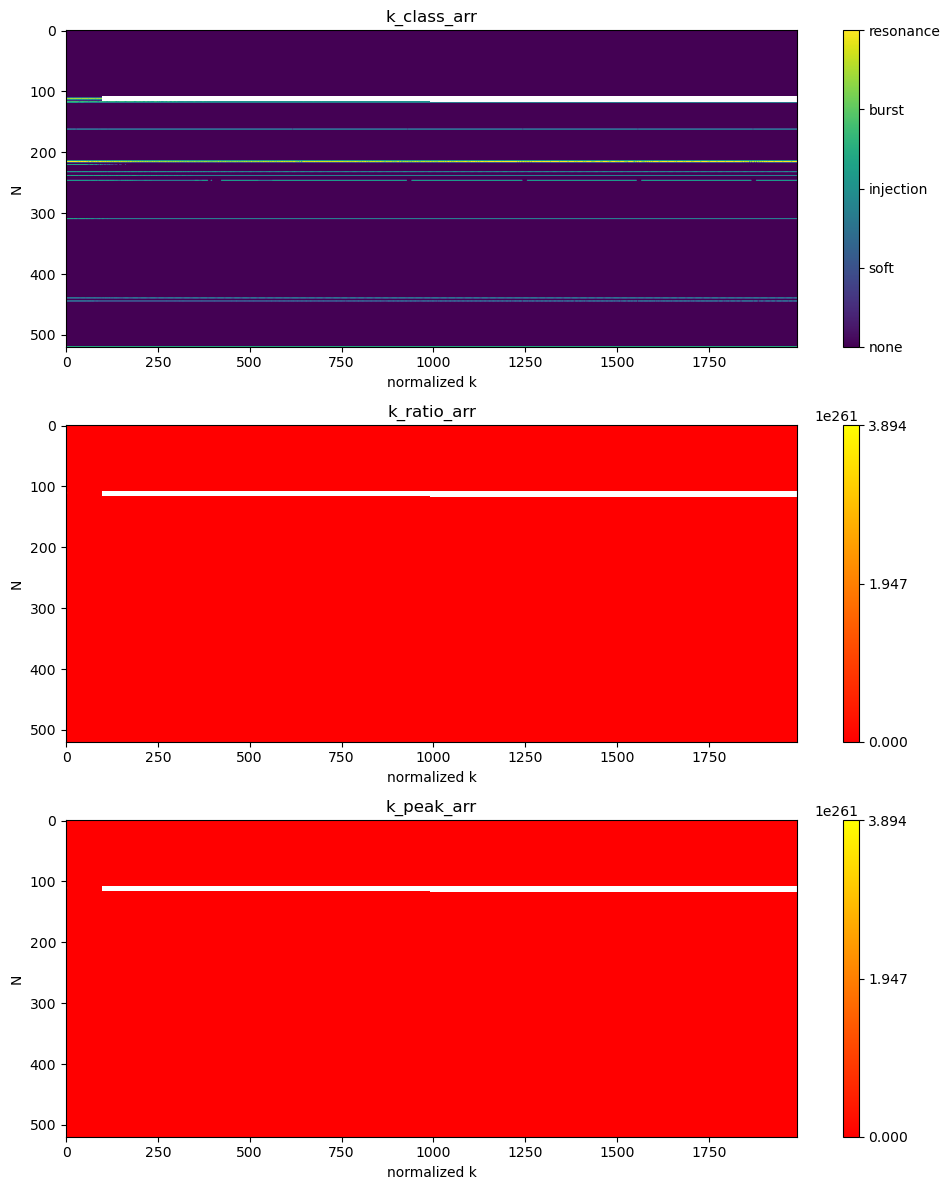

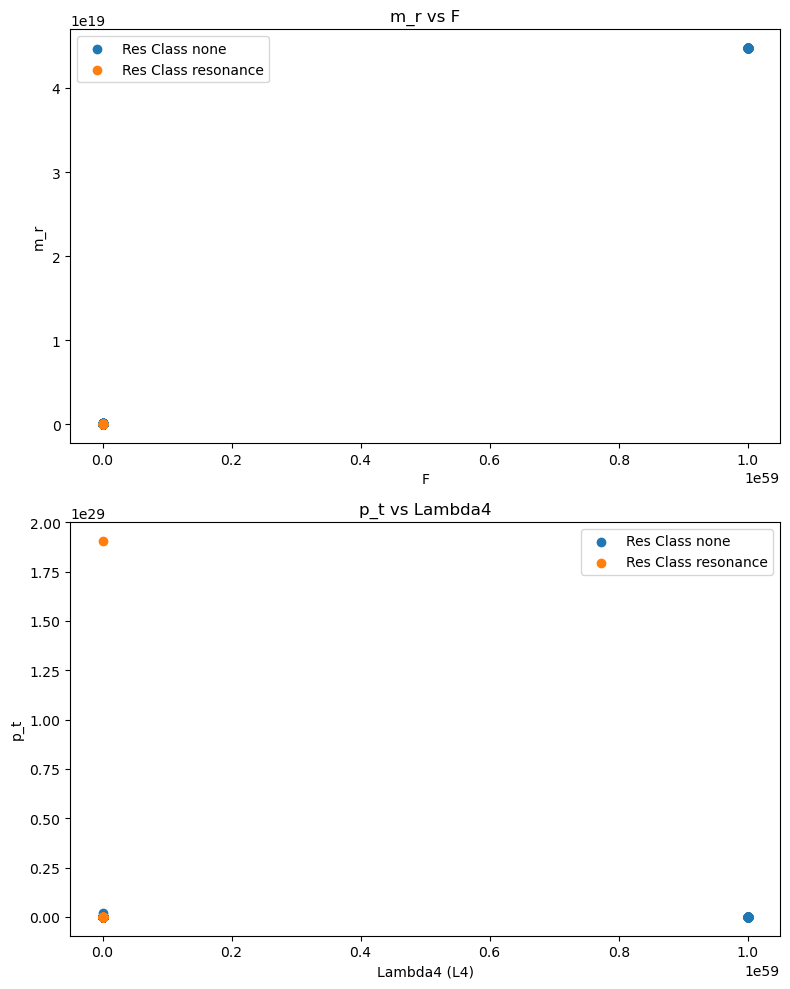

In [12]:
## WIP: Visualize imported data for a category of runs
plot_heatmaps(params_data)
plot_scatter(params_data)

In [13]:
## Analyze a run's plots TODO/WIP
if False:

    # Sample data (replace with actual data)
    #params, results, _, coeffs = load_single_result(filename='3_neutrals_5f6d4c42050e31fa8d06ce7d9fc526e1eff881f3', output_dir='./test_data/v2.8/3_neutrals/')
    

    # Placeholder for raw solution (replace with actual data when available)
    data = params_data
    raw_solution = results_data
    print(results_data)

    # Heatmap for raw solution
    plt.figure(figsize=(12, 8))
    sns.heatmap(raw_solution, cmap='viridis')
    plt.title("Heatmap of Raw Solution (Amplitude of Photon Field)")
    plt.xlabel("k-mode")
    plt.ylabel("Time")
    plt.show()

    # Bar plots for k_mean_arr, k_peak_arr, and k_sens_arr
    k_modes = np.arange(1, len(data["k_mean_arr"]) + 1)
    plt.figure(figsize=(12, 8))
    plt.bar(k_modes, data["k_mean_arr"], label="k_mean_arr", alpha=0.6)
    plt.bar(k_modes, data["k_peak_arr"], label="k_peak_arr", alpha=0.6)
    plt.bar(k_modes, data["k_sens_arr"], label="k_sens_arr", alpha=0.6)
    plt.xlabel("k-mode")
    plt.ylabel("Value")
    plt.title("Bar Plots for k_mean_arr, k_peak_arr, and k_sens_arr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Categorical plot for k_class_arr
    plt.figure(figsize=(12, 8))
    sns.countplot(data["k_class_arr"])
    plt.title("Distribution of Classification Labels")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


In [14]:
## TODO: k-mode instability (floquet) plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_k_vs_parameter_heatmap(df, parameter, mode='absolute'):
    # Extract global k range
    global_k_min = df['k_span'].apply(lambda x: x[0]).min()
    global_k_max = df['k_span'].apply(lambda x: x[1]).max()
    k_values = np.linspace(global_k_min, global_k_max, 500)  # Sampled k-values

    param_values = df[parameter].unique()
    heatmap_grid = np.zeros((len(param_values), len(k_values)))

    for i, param_val in enumerate(param_values):
        subset = df[df[parameter] == param_val]
        for j, k_val in enumerate(k_values):
            count = 0
            for _, row in subset.iterrows():
                k_min, k_max = row['k_span']
                if k_val >= k_min and k_val <= k_max:
                    index = np.argmin(np.abs(row['k_sens_arr'] - k_val))
                    if row['k_class_arr'][index] == 'res':
                        count += 1
            if mode == 'fraction':
                count /= len(subset)
            heatmap_grid[i, j] = count

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_grid, xticklabels=50, yticklabels=param_values, cmap="YlGnBu")
    plt.xlabel('k-values')
    plt.ylabel(parameter)
    title = f"Heatmap of 'res' count in k_class_arr vs. {parameter}"
    if mode == 'fraction':
        title += " (fraction)"
    plt.title(title)
    plt.show()

if False:
    plot_k_vs_parameter_heatmap(params_data, 'm_u')
    plot_k_vs_parameter_heatmap(params_data, 'F')
    plot_k_vs_parameter_heatmap(params_data, 'L4')
    plot_k_vs_parameter_heatmap(params_data, 'p_t')

In [15]:
## Correlation analysis and dataframe postprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_columns = None

# Convert dictionary to DataFrame for ease of manipulation
df_in = params_data.copy(deep=True)

## Handle list/dict structured parameters
df_arr_cols = ['qc', 'qm', 'xi', 'dqm', 'eps_c'] + \
              ['m_r', 'm_n', 'm_c', 'p_r', 'p_n', 'p_c'] + \
              ['res_band', 't_span', 'k_span']
              #['k_class', 'k_peak'] + \
df_subarrs = ['amps', 'd', 'Th'] # + ['m', 'p'] # + ['k_ratio']
df_dict_cols = ['res_freq_class']
df_arr_keys = {}
df_dict_keys = {}
def df_push_dict(dict_in, col_in, sub_cols_in):
    for x in sub_cols_in:
        dict_in[x] = dict_in[col_in]
    return dict_in
# Expand array-like features into discrete columns
df = df_in.copy(deep=True)
for col in df_arr_cols:
    columns = ['%s_%d' % (col, ex_idx) for ex_idx, _ in enumerate(df[col][0])]
    df_arr_keys[col] = columns
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series).add_prefix('%s_' % col)], axis=1)
for col in df_subarrs:
    columns = ['%s_%d' % (col, ex_idx) for ex_idx, _ in enumerate(df[col][0])]
    df_arr_keys[col] = columns
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series).add_prefix('%s_' % col)], axis=1)
    for sub_idx, sub_col in enumerate(df[columns]):
        sub_columns = ['%s_%d' % (sub_col, ex_idx) for ex_idx, _ in enumerate(df[sub_col][0])]
        df_arr_keys[sub_col] = sub_columns
        for col_x in sub_columns:
            print_fmt[col_x] = print_fmt[sub_col]
            dtype_map[col_x] = dtype_map[sub_col]
        df = pd.concat([df, df.pop('%s' % sub_col).apply(pd.Series).add_prefix('%s_' % sub_col)], axis=1)
# Do the same for dicts
for col in df_dict_cols:
    col_data = {'%s_%s' % (col, key): val for key,val in df[col][0].items()}
    columns = col_data.keys()
    for col_x in columns:
        print_fmt[col_x] = print_fmt[col]
        dtype_map[col_x] = dtype_map[col]
    df = pd.concat([df, df.pop('%s' % col).apply(pd.Series, index=columns)], axis=1)
    df_dict_keys[col] = columns

# Helper functions
is_arr_param = lambda p_col: p_col in df_arr_cols or p_col in df_subarrs
is_dict_param = lambda p_col: p_col in df_dict_cols
is_vectorized_param = lambda p_col: is_arr_param(p_col) or is_dict_param(p_col)
get_vectorized_cols = lambda p_col: df_arr_keys[p_col] if is_arr_param(p_col) else df_dict_keys[p_col] if is_dict_param(p_col) else print(p_col)
vec_col_set = lambda set_in: ((set(df_arr_cols + df_dict_cols) | (set(df_arr_keys.keys()) - set(df_subarrs))) & set(set_in))
vectorized_param_set = lambda set_in: \
    ((set(set_in) | set([vec_val for vec_col in [get_vectorized_cols(vec_col_in) for vec_col_in in vec_col_set(set_in)] for vec_val in vec_col])) - (vec_col_set(set_in) | set(df_subarrs)))

# Descriptive Statistics
if False:
    print(df.describe())
    print('-----------------------------------------------------------------')

## Organize parameters
# Parameters related to computational complexity and runtime performance
performance_inputs = ['num_cores', 'jupyter', 'parallel', 'use_mass_units', 'use_natural_units', 'k_num', 't_num', 'N_r', 'N_c', 'N_n', 'N_tot', 'mem_per_core', 'k_span', 't_span']
performance_outputs = ['time_elapsed']
primary_sim_settings = ['k_span', 't_span', 'int_method', 'res_con', 'k_num', 't_num']
secondary_sim_settings = ['A_sens', 't_sens']
tertiary_sim_settings = ['use_mass_units', 'use_natural_units', 'dimensionful_p', 'rescale_consts', 'unitful_amps', 'unitful_k', 'unitful_m', 'rescale_k', 'rescale_m', 'rescale_amps', 'rescale_consts']
sim_settings_parameters = primary_sim_settings + secondary_sim_settings + tertiary_sim_settings
# Input parameters
primary_inputs = ['F', 'm_q', 'eps', 'p_t', 'L4', 'L3']
secondary_inputs = ['A_0', 'Adot_0', 'A_pm', 'mu_Th', 'mu_d', 'sig_Th', 'sig_d']
tertiary_inputs = ['qc', 'xi', 'eps_c', 'qm', 'l1', 'l2', 'l3', 'l4', 'e', 'G', 'c', 'h']
input_parameters = primary_inputs + secondary_inputs + tertiary_inputs
# Dependent Parameters
primary_dependents = ['N_r', 'N_c', 'N_n', 'N_tot']
secondary_dependents = ['m_u', 't_u', 'm_0', 'k_0', 'p_0']
tertiary_dependents = ['dqm', 'm', 'm_r', 'm_n', 'm_c', 'p', 'p_r', 'p_n', 'p_c', 'amps', 'T_u', 'T_r', 'T_n', 'T_c']
dependent_parameters = primary_inputs + secondary_inputs + tertiary_inputs
k_dependents = ['k_class_arr', 'k_mean_arr', 'k_peak_arr', 'k_sens_arr']
# TODO: Maybe do correlation / metastatistics for sampled / dependent parameters as included parameters?
sampled_params = ['d', 'Th']
# Unused parameters
disabled_params = ['seed']
cosmetic_params = ['config_name']
# Output/classification parameters
primary_outputs = ['res_class', 'res_band_class']
secondary_outputs = ['res_band', 'res_freq', 'res_freq_class', 't_res', 'res_ratio_f', 'res_ratio_m']

# Create unique sets and split vector-shaped parameters into separate columns
performance_params = performance_inputs + performance_outputs + primary_inputs + \
                     primary_sim_settings + secondary_sim_settings + cosmetic_params
time_param_set = vectorized_param_set(performance_params)

correlation_params = primary_inputs + secondary_inputs + \
                     primary_sim_settings + sampled_params + \
                     primary_dependents + secondary_dependents + \
                     primary_outputs + secondary_outputs + cosmetic_params
corr_param_set = vectorized_param_set(correlation_params)

hidden_params = disabled_params + k_dependents + \
                tertiary_inputs + tertiary_sim_settings + tertiary_dependents

combined_params = correlation_params + performance_params + hidden_params
#print(combined_params)
combined_param_set = vectorized_param_set(combined_params)
#print(combined_param_set)

'''
if False: # Temp. prune parameters not found in older datasets
    new_params = ['res_freq', 'use_natural_units', 'res_band', 'use_mass_units', 'res_band_class']
    for new_param in new_params:
        if new_param not in df.columns:
            if new_param in corr_param_set:
                corr_param_set.remove(new_param)
            if new_param in time_param_set:
                time_param_set.remove(new_param)
            if new_param in combined_param_set:
                combined_param_set.remove(new_param)
'''

full_df = df[sorted(combined_param_set)]
#print(full_df)
corr_df = df[sorted(corr_param_set)]
time_df = df[sorted(time_param_set)]

# Identify any free parameters not being properly classified
unclassified_params = set(df_in.columns) - set(combined_params)
if len(unclassified_params) > 0:
    print('-----------------------------------------------------------------')
    print('Unclassified parameters: ')
    for col in unclassified_params:
        print('%s  : %s' % (col, df_in[col].dtype))

# Correlation Analysis
print('\nModel Parameters and Correlations')
print(df_describe(corr_df))
#print(df_pprint(corr_df))
correlation_matrix = corr_df.corr(numeric_only=True)
#print(df_pprint(correlation_matrix))
print('-----------------------------------------------------------------')

# Complexity Analysis
print('Time Complexity Parameters and Correlations')
print(df_describe(time_df))
time_corr_matrix = time_df.corr(numeric_only=True)
#print(df_pprint(time_corr_matrix))
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
Unclassified parameters: 
res_freq_label  : object
k_ratio_arr  : object

Model Parameters and Correlations
          A_0   A_pm  Adot_0             F            L3            L4  \
count   520.0  520.0   520.0  5.200000e+02  5.200000e+02  5.200000e+02   
unique    NaN    NaN     NaN           NaN           NaN           NaN   
top       NaN    NaN     NaN           NaN           NaN           NaN   
freq      NaN    NaN     NaN           NaN           NaN           NaN   
mean      1.0    1.0     1.0  1.250002e+58  1.173768e+20  1.576931e+58   
std       0.0    0.0     0.0  3.310373e+58  3.585611e+20  3.648028e+58   
min       1.0    1.0     1.0  1.000000e+14 -1.000000e+00  2.000000e+16   
25%       1.0    1.0     1.0  1.000000e+19  1.000000e+20  7.742637e+27   
50%       1.0    1.0     1.0  1.000000e+29  1.000000e+20  1.000000e+39   
75%       1.0    1.0     1.0  1.000000e+49  1.000000e+20  1.000000e+49   
max       1.

/users/sloane1/.conda/envs/piaxiverse/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/users/sloane1/.conda/envs/piaxiverse/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Including data from the following configurations:
    |  pi_axiverse_clump_full
    |  pi_axiverse_clump_sampled
    |  pi_axiverse_clump_simple
    |  pi_axiverse_jupyter
    |  pi_axiverse_local
    |  pi_axiverse_local_full
    |  pi_axiverse_local_sampled
    |  pi_axiverse_local_simple
    |  pi_axiverse_star
    |  pi_axiverse_star_SU3
    |  pi_axiverse_star_SU6
    |  pi_axiverse_star_full
    |  pi_axiverse_star_sampled
    |  pi_axiverse_star_simple
    |  pi_axiverse_star_single

Simulation settings:
          int_method :        RK45  []
Fixed params:
                 A_0 :         1.0  
                A_pm :           1  
              Adot_0 :         1.0  
               mu_Th :         1.0  [π]
                mu_d :         1.0  [π]
              sig_Th :         0.3  [π]
               sig_d :         0.3  [π]



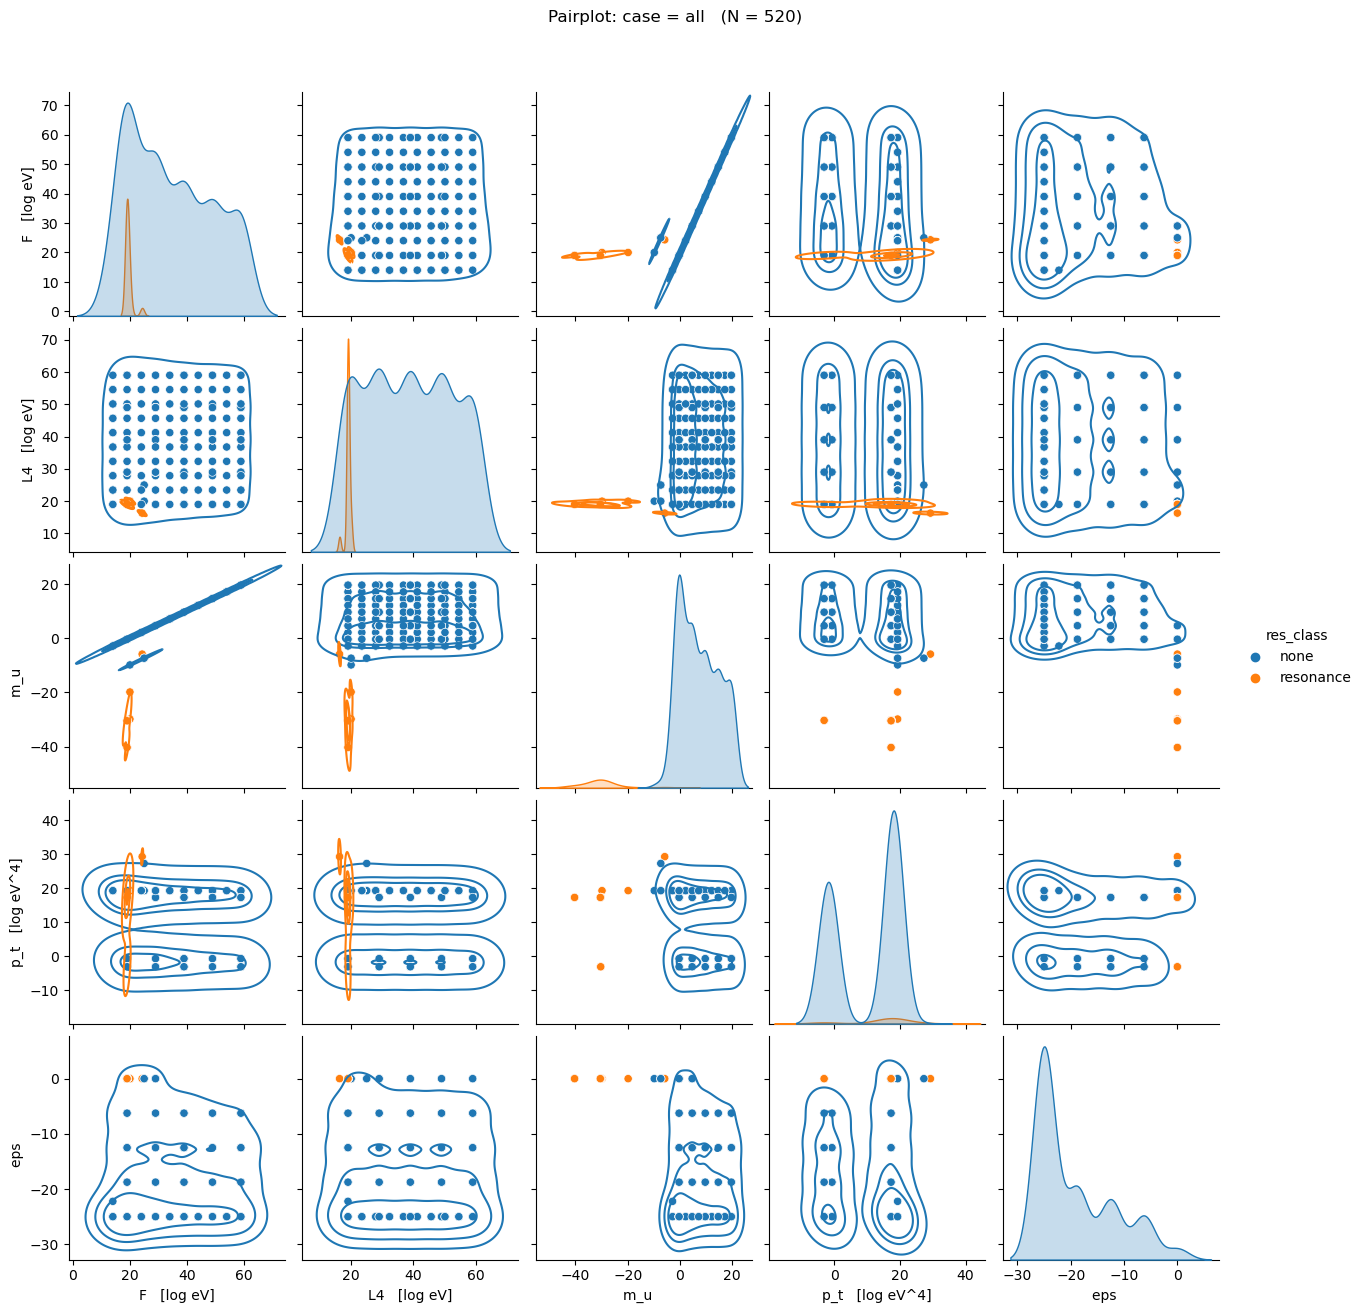

In [30]:
## WIP: Addititional/alternative Pairplot Visualization and importance estimation
show_histograms = False
show_pairplot   = True
show_heatmap    = False

log_params  = ['p_0', 'p_t', 'F', 'L3', 'L4', 'm_q', 'eps', 'res_ratio_f', 'res_ratio_m', 'm_0', 'k_0', 'm_u', 't_u']
dict_params = []
keep_params = ['res_class', 'config_name', 'units', 'res_band_class']

plot_params = ['F', 'L4', 'm_u', 'p_t', 'eps']
fixed_params = {}

# Filter and rescale data for plotting
filter_nonunique  = True
filter_sampled    = True
rescale_logparams = True
infs_to_nans = True
plot_data = corr_df.copy()

def drop_col(col_in, plot_data_in=plot_data, plot_params_in=plot_params):
    plot_data_in.drop(col_in, inplace=True, axis=1)
    if col_in in plot_params_in:
        plot_params_in.remove(col_in)

if infs_to_nans:
    plot_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in plot_data.columns:
    if rescale_logparams and col in log_params:
        plot_data[col] = np.log10(plot_data[col])
    if filter_sampled:
        if col in sampled_params and col not in keep_params:
            drop_col(col)
    if filter_nonunique:
        if len(plot_data[col].unique()) <= 1 and col not in keep_params:
            if col in input_parameters or col in sim_settings_parameters:
                fixed_params[col] = plot_data[col].unique()[0]
                drop_col(col)

# Print out which classes of runs are included in final dataset
if conf_name == 'all':
    print('Including data from the following configurations:')
    dataset_cases = plot_data['config_name'].unique()
    for data_case in dataset_cases:
        print('    |  %s' % data_case)

# TODO/WIP: Histograms
# TODO: Stacked plots with color code for resonance status?
if show_histograms:
    for column in plot_data.columns:
        #print(plot_data[column])
        x = plot_data[column]
        if column in log_params:
            title = 'log %s' % column
        else:
            title = '%s' % column
        plt.hist(x,bins='auto')
        plt.xlabel(title)
        plt.ylabel('N')
        plt.show()

# TODO: Scatter plots?

# TODO/WIP: Pairplots
#           WARNING: Takes a long time / lots of space if large numbers are not properly rescaled
if show_pairplot:
    # temp fix for seaborn version
    import warnings
    warnings.filterwarnings('ignore')
    # (Unused)
    hue_order = ['res_class']
    palette = {'resonance': 'red', 'semi': 'blue', 'none': 'grey', 'damp': 'grey'}
    # Format axes to show units
    fmt_col = lambda c_in: '%s   %s' % (c_in,units_fmt(c_in, prefix='log ' if c_in in log_params else ''))
    plot_data_units = plot_data.rename(columns={col: fmt_col(col) for col in plot_params})
    plot_params_units = [fmt_col(col) for col in plot_params]
    
    # kind = 'kde', 'scatter', 'hist', or 'reg'
    pp = sns.pairplot(plot_data_units, x_vars=plot_params_units, y_vars=plot_params_units, dropna=True, kind='scatter', diag_kind='kde', hue='res_class')
    pp.map_offdiag(sns.kdeplot, levels=4)
    pp.fig.suptitle('Pairplot: case = %s   (N = %d)' % (conf_name, len(plot_data.index)), y=1.05)

    print('\nSimulation settings:')
    for key, val in fixed_params.items():
        if key in sim_settings_parameters:
            print('%20s :  %10s  [%s]' % (key, str(val), units_fmt(key)))
    
    print('Fixed params:')
    for key, val in fixed_params.items():
        if key in input_parameters:
            print('%20s :  %10s  %s' % (key, str('%.1f' % val) if key in log_params else df_fmt(val, fmt=print_fmt[key]), units_fmt(key, prefix='log ' if key in log_params else '')))

    #print('Units: ')
    #print(param_units)

# TODO: Heatmap for correlation matrix
if show_heatmap:
    sns.heatmap(correlation_matrix, annot=True)

if np.any([show_histograms, show_pairplot, show_heatmap]):
    print('')
    plt.show()

## ML Analysis

0      nan
1      nan
2      nan
3      nan
4      nan
      ... 
515    nan
516    nan
517    nan
518    nan
519    nan
Name: res_freq, Length: 520, dtype: object
                F          L3          L4         N_c         N_n         N_r  \
count  520.000000  520.000000  520.000000  520.000000  520.000000  520.000000   
mean    33.925579   15.743269   37.852502    2.598077    1.728846    2.471154   
std     14.559835    7.988127   13.999868    2.611298    1.785603    1.096120   
min     14.000000   -1.000000   16.301030    0.000000    0.000000    1.000000   
25%     19.000000   20.000000   27.888889    2.000000    1.000000    2.000000   
50%     29.000000   20.000000   39.000000    2.000000    1.000000    2.000000   
75%     49.000000   20.000000   49.000000    2.000000    1.000000    2.000000   
max     59.000000   21.500000   59.000000    9.000000    6.000000    5.000000   

            N_tot  config_name         eps        k_num    k_span_1  \
count  520.000000   520.000000  520

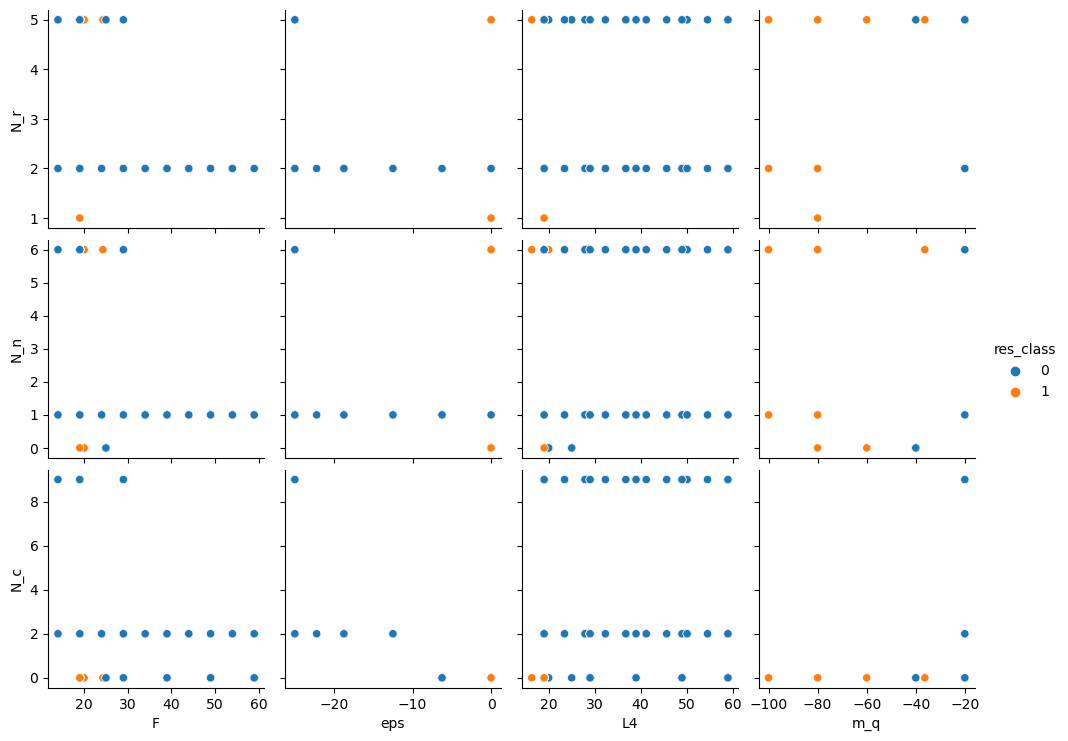

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [26]:
## Preprocess data for ML analysis pipeline and assign numerical labels to string-valued parameters
from sklearn import preprocessing
X_df = pd.DataFrame.copy(corr_df, deep=True)
print(X_df['res_freq'])
X_df['res_freq'] = X_df['res_freq'].map(lambda x: np.nan if x is None or x == 'None' else x, na_action='ignore')
le = preprocessing.LabelEncoder()
label_cols = ['config_name', 'int_method', 'res_class', 'res_band_class', 'res_band_0', 'res_band_1']
filter_nonunique = True
for col in X_df:
    if col in label_cols:
        X_df[col] = le.fit_transform(X_df[col])
    if col in log_params:
        X_df[col] = np.log10(X_df[col])
    if filter_nonunique:
        if len(X_df[col].unique()) <= 1 and col not in keep_params:
            #if col in input_parameters or col in sim_settings_parameters:
                drop_col(col, plot_data_in=X_df, plot_params_in=[])

overwrite_nans = True
if overwrite_nans:
    X_df = X_df.map(lambda x: -1 if pd.isnull(x) or x == np.nan else x)
print(X_df.describe())

# Pair plot for N_r, N_n, N_c, F
pp = sns.pairplot(X_df,  x_vars=['F', 'eps', 'L4', 'm_q'], y_vars=['N_r', 'N_n', 'N_c'], hue='res_class')
plt.show()

# Split data into train and test
train, test = train_test_split(X_df, test_size=0.3)

# Separate inputs and outputs
#output_params = ['res_class']
output_params = ['res_class', 'res_ratio_f', 'res_ratio_m', 'res_freq_class', 'res_band_class', 'time_elapsed']
dependent_params = ['m_0', 'm_u', 't_u']
train_params = [out_param for out_param in output_params if out_param in train.columns]
drop_params = train_params + dependent_params

X_train = train.drop(columns=drop_params)
y_train = train[train_params]
X_test = test.drop(columns=drop_params)
y_test = test[train_params]

# Model training and prediction
clf = RandomForestClassifier()
clf.fit(X_train, y_train['res_class'])  # For 'res_class', repeat for others
# Feature Importance
res_importance = clf.feature_importances_

## Visualization
# Plot feature importance
sns.barplot(x=res_importance, y=X_train.columns)
#plt.show()

In [27]:
## Optical Depth Calculations (WIP)
if True:
    import numpy as np
    c = 2.998e10   # [cm/s]
    h = 6.582e-16  # [eV s]
    G = 6.674e-13  # [N cm^2/g^2]
    
    # parameters of theory
    l1 = l2 = l3 = l4 = 1.  # unitless
    L3 = L4 = 1e11          # [eV]
    example_eps = 1.        # unitless
    example_Fpi = 1e21      # [eV]
    unitless_e  = 0.3       # unitless electron charge
    M_planck = np.sqrt(h*2*np.pi*c/G)
    
    ## Scattering Cross-Section
    k_example = 1          # [m]  =  3.85e+13 [Hz]
    m_example = 1          # [m]
    u_example = 1.414e-06  # [eV]
    coupling_example = 1
    cutoff_example = 1e5   # [eV]
    
    cs_to_units = lambda cs: cs * (h ** 2) * (c**3)
    # crossterm FFdual
    cross_sec_1 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: (((l ** 2) * m)/(6*np.pi*(L**4))) * ((k ** 4)/((m + 2*k)**3))
    # pi_0 FFdual (TODO)
    cross_sec_0 = lambda k=k_example, m=m_example, l=coupling_example, L=cutoff_example, c=c, h=h, G=G: 0
    
    print('Example cross-section values:')
    #print('   sigma_0 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_0(), cs_to_units(cross_sec_0())))
    print('   sigma_1 = %.3e [eV]^-2 = %.3e [cm]^2' % (cross_sec_1(), cs_to_units(cross_sec_1())))
    
    ## Optical Depth
    density_example = 4e9   # [eV/cm^3]
    
    # Simple optical depth calculation (tau = sigma * n)
    tau_simple = lambda cs, rho=density_example, m_u=u_example, c=c: (rho/m_u) * cs_to_units(cs)
    # Weinberg calculation
    # TODO: check the definitions and units on these
    tau_weinberg = lambda cs, rho=density_example, m_u=u_example, k_u=u_example, k_peak=k_example, k_step=1, k_max=cutoff_example, c=c: (rho/m_u) / ((k_u*k_peak*c)*h) * np.sum([cs(k) for k in np.arange(1,cutoff_example,k_step)])
    
    print('\nExample optical depth values:')
    #print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0()))
    #print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0()))
    print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1()))
    print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1))

Example cross-section values:
   sigma_1 = 1.965e-23 [eV]^-2 = 2.294e-22 [cm]^2

Example optical depth values:
   tau_1 (simple) = 6.489e-07 [cm]^-1
   tau_1 (weinberg) = 3.362e+13 [???]


In [28]:
### Length Scales of different astrophysical scenarios
##       - TODO:  Astrophysical or formation motivated reasoning for selecting a given Mass or Radius to solve for, given density
##       - TODO:  Axion minicluster (planetary), Axion star, axion clump (~5 parsec), axion DM galaxy halo, galaxy supercluster-sized halo

## TODO: - Compare different length scales and energy density values against optical depth.
##       - Sanity check to ensure that optical depth is not too high

M_sun    = 1.988e33    # [g]
M_sun_eV = 1.115e66    # [eV/c^2]
g_to_eV  = 5.61e32     # [eV/c^2]
pc_to_cm = 3.086e18    # [cm]

## Axion Stars
R_star = 1.          # [cm], can be determined by mass
M_star = 1.          # [m_sun], can be determined by radius
# ALP properties
m_axion = (m_example * u_example)
g_axion = (coupling_example / cutoff_example)
# axion decay constant
f_axion = example_Fpi
# initial axion field amplitude
a_0 = 1.

## Axion star radius relations
# TODO: Find a better reference than (Iwazaki 2022), whose units don't make any sense
# note: per above, R_star ~ 1/k_axion
fixed_M = True
if fixed_M:
    R_star = 1./(G * m_axion**2 * (M_star*M_sun))
else:
    M_star = (np.pi * (1./2) * (m_axion/g_to_eV)**2 * (f_axion/(g_to_eV * c**2))**2 * a_0**2 * R_star**3) / M_sun

# Critical Coupling (Chung-Jukko 2023)
# (values of coupling constant above this will rapidly decay via parametric resonance)
g_crit = (1.66e-17)/(1e9) * ((M_star)*(m_axion/1e-11))**(-1.35)     # [eV]^-1
# (timescale of decay)
t_crit = (g_axion - g_crit)**(-0.87)     # [TODO: units???]

# Axion star energy density
rho_star = (M_star*M_sun*g_to_eV)/((4/3)*np.pi*R_star**3)    # [eV / cm^3]

# Axion star optical properties:
print('Axion Star:')
print('   M = %.1f [m_sun]   |   R = %.3e [cm]   |   rho = %.3e [eV/cm^3]  |   m_a = %.3e [eV]   |   g_crit = %0.1e [eV]^-1' % (M_star, R_star, rho_star, m_axion, g_crit))
print('Optical Depth: ')
#print('   tau_0 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_0(), rho=rho_star, m_u=m_axion))
#print('   tau_0 (weinberg) = %.3e [cm]^-1' % tau_weinberg(cross_sec_0(), rho=rho_star, m_u=m_axion))
print('   tau_1 (simple) = %.3e [cm]^-1' % tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_simple(cross_sec_1(), rho=rho_star, m_u=m_axion)*R_star))
print('   tau_1 (weinberg) = %.3e [???]' % tau_weinberg(cross_sec_1, rho=rho_star, m_u=m_axion))
print('   tau(R) = %.3e' % (tau_weinberg(cross_sec_1, rho=rho_star, m_u=m_axion)*R_star))

## TODO: Axion Miniclusters

## TODO: Axion Halos

Axion Star:
   M = 1.0 [m_sun]   |   R = 3.770e-10 [cm]   |   rho = 4.970e+93 [eV/cm^3]  |   m_a = 1.414e-06 [eV]   |   g_crit = 1.8e-33 [eV]^-1
Optical Depth: 
   tau_1 (simple) = 8.063e+77 [cm]^-1
   tau(R) = 3.039e+68
   tau_1 (weinberg) = 4.177e+97 [???]
   tau(R) = 1.575e+88


In [29]:
# TODO: Neural Network parameter analysis
# - 3 (?) fully-connected input layers (to capture nonlinearity?)
#    - N = number of inputs? of all parameters? of arbitrarity selection of choice?
# - Variational autoencoder
#    - Depth = ???
#    - # of hidden layers / dimensionality of gaussian = ??? 
# (number of dependent variables? number of species? number of interaction vertices? arbitrary choice? compare quality of prediction and convergence speed / overfitting error for different N-1 to 0)